In [271]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import librosa

In [272]:
class Quantizer(nn.Module):
    def __init__(self, start, stop, n_bins=64, logspace=False, base=10, eps=1e-4):
        super().__init__()
        self.n_bins = 32
        self.start = start
        self.stop = stop
        self.logspace = logspace
        self.base = base
        self.eps = eps
        
        if self.logspace:
            self.bins = torch.logspace(
                start=np.log(self.start + self.eps) / np.log(base),
                end=np.log(self.stop + eps) / np.log(base),
                steps=self.n_bins,
                base=self.base
            )
        else:
            self.bins = torch.linspace(start, stop, n_bins)
            
        self.lookup_bins = torch.cat([
            self.bins[None, 0],
            0.5*self.bins[:-1] + 0.5*self.bins[1:],
            self.bins[None, -1]
        ])  
        
    def signal_to_ids(self, x):
        if self.logspace:
            # adding eps prevents instabilities
            x += self.eps
        return torch.bucketize(x, self.bins, right=False)
    
    def ids_to_signal(self, ids):
        lookup_bins = self.lookup_bins.view(*(1,) * (ids.dim() - 1), -1).expand(*ids.shape[:-1], -1)
        x_hat = lookup_bins.gather(-1, ids)
        if self.logspace:
            x_hat -= self.eps
        return  x_hat
    
    def quantize(self, x):
        return self.forward(x)
    
    def forward(self, x):
        return self.ids_to_signal(self.signal_to_ids(x))
    

In [313]:
class AudioModule(nn.Module):
    def __init__(
        self,
        n_fft=512, 
        d_model=512, 
        n_heads=8, 
        num_layers=6, 
        n_bins=128, 
        phase_attention_window=4
    ):
        super().__init__()
        
        self.n_fft = n_fft
        self.d_model = d_model
        self.n_heads = n_heads
        self.num_layers = num_layers
        self.n_bins = n_bins
        self.phase_attention_window = phase_attention_window
        
        self.amp_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=self.n_heads,
                dim_feedforward=self.n_heads*256,
                batch_first=True
            ),
            num_layers=self.num_layers
        )
        self.phase_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=self.n_heads,
                dim_feedforward=self.n_heads*256,
                batch_first=True
            ),
            num_layers=self.num_layers
        )
        
        self.d_fft = self.n_fft//2 + 1
        
        if self.d_fft != self.d_model:
            self.amp_proj = nn.Linear(self.d_fft, self.d_model, bias=False)
        else:
            self.amp_proj = nn.Identity()
        
        if 2*self.d_fft != self.d_model:
            self.phase_proj = nn.Linear(2*self.d_fft, self.d_model, bias=False)
        else:
            self.phase_proj = nn.Identity()
            
        self.amp_clf = nn.Linear(self.d_model, self.d_fft*self.n_bins, bias=False)
        self.phase_clf = nn.Linear(self.d_model, self.d_fft*self.n_bins, bias=False)
        
        self.amp_quantizer = Quantizer(0, 1, n_bins=self.n_bins, logspace=True)
        self.phase_quantizer = Quantizer(-np.pi, np.pi, n_bins=self.n_bins)
        
    def predict_amp(self, amp):
        seq_len = amp.size(1)
        attention_mask = torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=amp.device), diagonal=1)
        
        x_amp = self.amp_proj(amp)
        hiddens = self.amp_transformer(x_amp, mask=attention_mask)
        logits = self.amp_clf(hiddens)
        return logits.reshape(*logits.shape[:-1], -1, self.n_bins)
    
    def predict_phase(self, amp, phase):
        # amp[:, t] is amplitudes at current time step (labels)
        # phase[:, t] is phase at previous time step (input)
        assert amp.size(1) == phase.size(1), "amp and phase don't have the same length"
        seq_len = amp.size(1)
        device = amp.device
        
        # only allow attention to the last phase_attention_window time steps
        attention_mask = torch.tril(torch.full((seq_len, seq_len), float('-inf')), diagonal=-self.phase_attention_window) + \
                         torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
        
        x_phase = torch.cat([amp, phase], dim=-1)
        x_phase = self.phase_proj(x_phase)
        hiddens = self.phase_transformer(x_phase, mask=attention_mask)
        logits = self.phase_clf(hiddens)
        return logits.reshape(*logits.shape[:-1], -1, self.n_bins)
        
    def forward(self, amp, phase, amp_labels=None):
        # predict distribution of next amp
        amp_next = self.predict_amp(amp)
        # if no amp label is provided, sample the predicted distribution
        if amp_labels is None:
            amp_labels = self.sample_amp(amp_next)
            
        amp_inputs = self.amp_quantizer.ids_to_signal(amp_labels)
        # predict distribution of next phase
        phase_next = self.predict_phase(amp_inputs, phase)
        # return predicted distributions
        return amp_next, phase_next
    
    def _window(self):
        return torch.hann_window(self.n_fft + 2)[1:-1]
    
    def audio_to_spectrogram(self, x):
        z = torch.stft(x, n_fft=self.n_fft, hop_length=self.n_fft//2, return_complex=True, onesided=True, center=False, window=self._window())
        return z.transpose(-1, -2)
    
    def spectrogram_to_audio(self, z):
        z = z.transpose(-1, -2)
        x = torch.istft(z, n_fft=self.n_fft, hop_length=self.n_fft//2, onesided=True, center=False, window=self._window())
        return x
        
    def get_loss(self, x):
        batch_size = x.size(0)
        
        z = self.audio_to_spectrogram(x)
        
        seq_len = z.size(1)
        
        amp = z.abs()
        phase = z.angle()
        
        amp_inputs = self.amp_quantizer.quantize(amp[:, :-1])
        amp_labels = self.amp_quantizer.signal_to_ids(amp[:, 1:])
        
        phase_inputs = self.phase_quantizer.quantize(phase[:, :-1])
        phase_labels = self.phase_quantizer.signal_to_ids(phase[:, 1:])
        
        amp_pred, phase_pred = self.forward(amp_inputs, phase_inputs, amp_labels=amp_labels)
        
        amp_loss = F.cross_entropy(amp_pred.view(-1, amp_pred.size(-1)), amp_labels.view(-1)) / (batch_size * seq_len)
        phase_loss = F.cross_entropy(phase_pred.view(-1, phase_pred.size(-1)), phase_labels.view(-1)) / (batch_size * seq_len)
        
        return amp_loss + phase_loss
        

In [314]:
model = AudioModule()

In [324]:
x, sr = librosa.load('../datasets/fma_small/146/146017.mp3', mono=True, sr=44100)
x

/Users/dimitri/opt/miniconda3/envs/music-gen/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


array([ 0.        ,  0.        ,  0.        , ..., -0.04415894,
       -0.0473175 , -0.06245422], dtype=float32)

In [335]:
x, sr = librosa.load('../datasets/fma_small/146/146017.mp3', mono=True, sr=22050, duration=60)
#x = x / np.abs(x).max()
Audio(x, rate=sr)

/Users/dimitri/opt/miniconda3/envs/music-gen/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [ ]:
x = torch.from_numpy(x).split(65*256)
x = torch.stack(x[:-1])

In [316]:
x.shape

torch.Size([21, 16640])

In [317]:
model.get_loss(x[:8])

tensor(0.0196, grad_fn=<AddBackward0>)

In [ ]:
import matplotlib.pyplot as plt

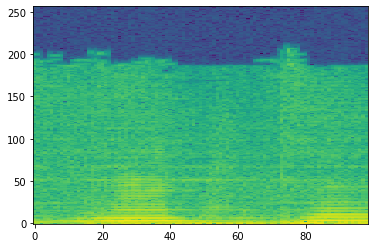

In [149]:
plt.imshow(z.abs()[-1].t().log(), aspect="auto", interpolation="none", origin="lower")

In [150]:
x_hat = model.spectrogram_to_audio(z)

In [155]:
from IPython.display import Audio
x_hat = x_hat.view(-1).numpy()
Audio(x_hat, rate=sr)